In [46]:
import warnings, os, theano, csv, pickle, time, gc

import numpy as np
import pandas as pd
from itertools import chain
from itertools import product as iterproduct
from pandarallel import pandarallel
import seaborn as sns
import tensorflow as tf
from collections import Counter
from sgt import SGT
from PIL import Image
import glob as glob
from pysam import FastaFile
from Bio import SeqIO
from kmodes.kmodes import KModes

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

import sklearn.metrics
from sklearn import svm, tree
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, normalize, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA

from keras.datasets import imdb
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Dense, Flatten, Convolution2D, MaxPooling2D, Input, Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Flatten, Embedding, Conv1D, BatchNormalization, MaxPooling1D, Add
from tensorflow.keras.preprocessing import sequence

%matplotlib inline


In [60]:
# Download data

path = 'uniprot_data'

with open(path) as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

protein_data = pd.DataFrame(d[1:], columns =d[0])
print(len(protein_data['Entry'].unique()))
print(len(protein_data))
protein_data.head()

20375
20375


,Entry,Entry name,Protein names,Gene names,Organism,Length,Function [CC],Sequence,Taxonomic lineage (all),Organism ID,Gene names (ORF ),Gene names (primary ),Gene names (synonym ),Protein families,Keywords,Mass,Protein existence,UniParc,Interacts with,Features
0,Q96NG5,ZN558_HUMAN,Zinc finger protein 558,ZNF558,Homo sapiens (Human),402,FUNCTION: May be involved in transcriptional r...,MAAVILPSTAAPSSLFPASQQKGHTQGGELVNELLTSWLRGLVTFE...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,,ZNF558,,Krueppel C2H2-type zinc-finger protein family,Alternative splicing;DNA-binding;Metal-binding...,"45,755",Evidence at protein level,UPI000006D81E,P49760; P68400; O95967; Q8N9N8; P57764; Q96MH2...,Alternative sequence (1); Chain (1); Domain (1...
1,Q6ZN19,ZN841_HUMAN,Zinc finger protein 841,ZNF841,Homo sapiens (Human),808,FUNCTION: May be involved in transcriptional r...,MLEGHESYDTENFYFREIRKNLQEVDFQWKDGEINYKEGPMTHKNN...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,,ZNF841,,Krueppel C2H2-type zinc-finger protein family,Alternative splicing;DNA-binding;Isopeptide bo...,"93,148",Evidence at protein level,UPI000035E7BB,,Alternative sequence (2); Chain (1); Cross-lin...
2,Q9UI25,YP002_HUMAN,Putative uncharacterized protein PRO0461,PRO0461,Homo sapiens (Human),63,,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,PRO0461,,,,Reference proteome,"6,971",Uncertain,UPI0000131026,,Chain (1)
3,Q86XN6,ZN761_HUMAN,Zinc finger protein 761,ZNF761 KIAA2033,Homo sapiens (Human),746,FUNCTION: May be involved in transcriptional r...,MAFSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVS...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,,ZNF761,KIAA2033,Krueppel C2H2-type zinc-finger protein family,DNA-binding;Isopeptide bond;Metal-binding;Nucl...,"87,716",Evidence at protein level,UPI0001825C19,,Chain (1); Cross-link (1); Domain (1); Erroneo...
4,A8MUZ8,Z705G_HUMAN,Putative zinc finger protein 705G,ZNF705G,Homo sapiens (Human),300,FUNCTION: May be involved in transcriptional r...,MHSLKKLTFEDVAIDFTQEEWAMMDTSKRKLYRDVMLENISHLVSL...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,,ZNF705G,,Krueppel C2H2-type zinc-finger protein family,DNA-binding;Metal-binding;Nucleus;Reference pr...,"34,765",Evidence at transcript level,UPI0001761700,,Chain (1); Domain (1); Zinc finger (4)


In [3]:
print(protein_data['Sequence'])

0        MAAVILPSTAAPSSLFPASQQKGHTQGGELVNELLTSWLRGLVTFE...
1        MLEGHESYDTENFYFREIRKNLQEVDFQWKDGEINYKEGPMTHKNN...
2        MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...
3        MAFSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVS...
4        MHSLKKLTFEDVAIDFTQEEWAMMDTSKRKLYRDVMLENISHLVSL...
                               ...                        
20370    MSLWGLVSKMPPEKVQRLYVDFPQHLRHLLGDWLESQPWEFLVGSD...
20371    MVLADLGRKITSALRSLSNATIINEEVLNAMLKEVCTALLEADVNI...
20372    MASLTVKAYLLGKEDAAREIRRFSFCCSPEPEAEAEAAAGPGPCER...
20373    MAAEKQVPGGGGGGGSGGGGGSGGGGSGGGRGAGGEENKENERPSA...
20374    MSLYDDLGVETSDSKTEGWSKNFKLLQSQLQVKKAALTQAKSQRTK...
Name: Sequence, Length: 20375, dtype: object


In [4]:
# DISGENET DATASET 1

disgenet_df = pd.read_csv("browser_source_genes_summary.tsv", sep='\t')
print("There began with " + str(len(disgenet_df)) + " rows in the Disgnet data")

# remove rows with NaN UniProt
clean_disgenet_df = disgenet_df[disgenet_df['UniProt'].notna()]
print("There are now " + str(len(clean_disgenet_df)) + " rows with NaN UniProt values removed")

## To visualize duplicate rows based on UniProt
# clean_disgenet_df[clean_disgenet_df.duplicated('UniProt')]

## Keep first occurence of duplicate UniProts
clean_disgenet_df = clean_disgenet_df.groupby('UniProt').first()
print("There are now " + str(len(clean_disgenet_df)) + " rows in the Disgenet data after removing duplicate UniProts")

clean_disgenet_df.head()

There began with 21671 rows in the Disgnet data
There are now 17158 rows with NaN UniProt values removed
There are now 16965 rows in the Disgenet data after removing duplicate UniProts


,Gene,Gene_id,Gene_Full_Name,Protein_Class,pLI,DSI_g,DPI_g,N_diseases,N_SNPs
UniProt,,,,,,,,,
A0A075B6H7,IGKV3-7,28915,immunoglobulin kappa variable 3-7 (non-functio...,None,NaN,0.890,0.154,3,0
A0A075B6I4,IGLV10-54,28772,immunoglobulin lambda variable 10-54,Immune response,NaN,0.890,0.115,9,22
A0A075B6I6,IGLV1-50,28821,immunoglobulin lambda variable 1-50 (non-funct...,None,NaN,0.931,0.077,2,0
A0A075B6I7,IGLV5-48,28780,immunoglobulin lambda variable 5-48 (non-funct...,None,NaN,1.000,0.038,1,0
A0A075B6J9,IGLV2-18,28814,immunoglobulin lambda variable 2-18,Immune response,NaN,0.931,0.038,2,0


In [5]:
clean_disgenet_df[clean_disgenet_df["Gene"] == "ESR1"]

,Gene,Gene_id,Gene_Full_Name,Protein_Class,pLI,DSI_g,DPI_g,N_diseases,N_SNPs
UniProt,,,,,,,,,
P03372,ESR1,2099,estrogen receptor 1,Nuclear receptor,0.9992,0.324,0.962,1101,185


In [6]:
# Join protein data (UniProt) and disease data (Disgenet)

protein_gene_df = pd.merge(protein_data, clean_disgenet_df,how='left', left_on='Entry', right_on='UniProt')

print("The number of original protein sequences is " + str(len(protein_data)))
print("The number of disease rows is " + str(len(clean_disgenet_df)))
print("After joining, there are still " + str(len(protein_gene_df)) + " rows of protein sequences")

protein_gene_df.head()


The number of original protein sequences is 20375
The number of disease rows is 16965
After joining, there are still 20375 rows of protein sequences


,Entry,Entry name,Protein names,Gene names,Organism,Length,Function [CC],Sequence,Taxonomic lineage (all),Organism ID,...,Features,Gene,Gene_id,Gene_Full_Name,Protein_Class,pLI,DSI_g,DPI_g,N_diseases,N_SNPs
0,Q96NG5,ZN558_HUMAN,Zinc finger protein 558,ZNF558,Homo sapiens (Human),402,FUNCTION: May be involved in transcriptional r...,MAAVILPSTAAPSSLFPASQQKGHTQGGELVNELLTSWLRGLVTFE...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,Alternative sequence (1); Chain (1); Domain (1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q6ZN19,ZN841_HUMAN,Zinc finger protein 841,ZNF841,Homo sapiens (Human),808,FUNCTION: May be involved in transcriptional r...,MLEGHESYDTENFYFREIRKNLQEVDFQWKDGEINYKEGPMTHKNN...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,Alternative sequence (2); Chain (1); Cross-lin...,ZNF841,284371.0,zinc finger protein 841,Transcription factor,2.393100e-02,1.0,0.077,1.0,1.0
2,Q9UI25,YP002_HUMAN,Putative uncharacterized protein PRO0461,PRO0461,Homo sapiens (Human),63,,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,Chain (1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q86XN6,ZN761_HUMAN,Zinc finger protein 761,ZNF761 KIAA2033,Homo sapiens (Human),746,FUNCTION: May be involved in transcriptional r...,MAFSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVS...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,Chain (1); Cross-link (1); Domain (1); Erroneo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A8MUZ8,Z705G_HUMAN,Putative zinc finger protein 705G,ZNF705G,Homo sapiens (Human),300,FUNCTION: May be involved in transcriptional r...,MHSLKKLTFEDVAIDFTQEEWAMMDTSKRKLYRDVMLENISHLVSL...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,Chain (1); Domain (1); Zinc finger (4),ZNF705G,100131980.0,zinc finger protein 705G,None,1.647100e-08,NaN,NaN,1.0,1.0


In [7]:
# DISGENET DATASET 2

disgenet_common_disease_df = pd.read_csv("browser_source_summary_gda.tsv", sep='\t')
disgenet_common_disease_df = disgenet_common_disease_df.groupby('Gene')['Disease'].apply(lambda x: x.value_counts().index[0]).reset_index()

print("There are " + str(len(disgenet_common_disease_df)) + " diseases considered in the dataset.")
disgenet_common_disease_df.head()


There are 21666 diseases considered in the dataset.


,Gene,Disease
0,A1BG,Adenocarcinoma
1,A1BG-AS1,Primary malignant neoplasm
2,A1CF,Malaria
3,A2M,Venous Thromboembolism
4,A2ML1,Abnormal hair quantity


In [8]:
# Join protein data (UniProt) and new disease data (Disgenet)

protein_disease_df = pd.merge(protein_gene_df, disgenet_common_disease_df,how='left', left_on='Gene names', right_on='Gene')

print("The number of original protein sequences is " + str(len(protein_data)))
print("The number of disease rows is " + str(len(disgenet_common_disease_df)))
print("After joining, there are still " + str(len(protein_disease_df)) + " rows of protein sequences")

protein_disease_df.head()

The number of original protein sequences is 20375
The number of disease rows is 21666
After joining, there are still 20375 rows of protein sequences


,Entry,Entry name,Protein names,Gene names,Organism,Length,Function [CC],Sequence,Taxonomic lineage (all),Organism ID,...,Gene_id,Gene_Full_Name,Protein_Class,pLI,DSI_g,DPI_g,N_diseases,N_SNPs,Gene_y,Disease
0,Q96NG5,ZN558_HUMAN,Zinc finger protein 558,ZNF558,Homo sapiens (Human),402,FUNCTION: May be involved in transcriptional r...,MAAVILPSTAAPSSLFPASQQKGHTQGGELVNELLTSWLRGLVTFE...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q6ZN19,ZN841_HUMAN,Zinc finger protein 841,ZNF841,Homo sapiens (Human),808,FUNCTION: May be involved in transcriptional r...,MLEGHESYDTENFYFREIRKNLQEVDFQWKDGEINYKEGPMTHKNN...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,284371.0,zinc finger protein 841,Transcription factor,2.393100e-02,1.0,0.077,1.0,1.0,ZNF841,Asthma
2,Q9UI25,YP002_HUMAN,Putative uncharacterized protein PRO0461,PRO0461,Homo sapiens (Human),63,,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q86XN6,ZN761_HUMAN,Zinc finger protein 761,ZNF761 KIAA2033,Homo sapiens (Human),746,FUNCTION: May be involved in transcriptional r...,MAFSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVS...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A8MUZ8,Z705G_HUMAN,Putative zinc finger protein 705G,ZNF705G,Homo sapiens (Human),300,FUNCTION: May be involved in transcriptional r...,MHSLKKLTFEDVAIDFTQEEWAMMDTSKRKLYRDVMLENISHLVSL...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,100131980.0,zinc finger protein 705G,None,1.647100e-08,NaN,NaN,1.0,1.0,ZNF705G,Blood Protein Measurement


In [9]:
#EDA

In [10]:
eda_df = protein_disease_df.copy()

In [11]:
# EDA Functions

def plot_seq_count(df, data_name):
  sns.displot(df['seq_char_count'].values)
  plt.title(f'Sequence of Characters' + data_name)
  plt.grid(True)

def get_code_freq(df, data_name):
  df = df.apply(lambda x: " ".join(x))
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)
  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')
  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

def plot_code_freq(df, data_name):
  plt.title(f'')
  sns.barplot(x='Code', y='Freq', data=df)
    
    
#TEXT PREPROCESSING
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict

def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  encode_list = []
  for row in data['Sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  return encode_list
  

In [12]:
# Set up amino acid dictionary

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

char_dict = create_dict(amino_acids)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


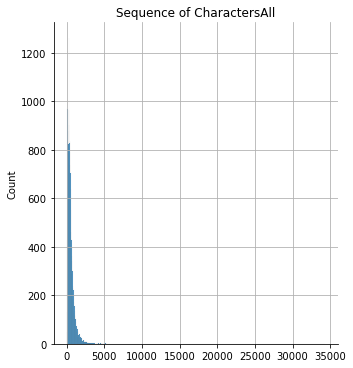

In [13]:
# Plot sequence character count

eda_df['seq_char_count'] = eda_df['Sequence'].apply(lambda x: len(x))
plot_seq_count(eda_df, 'All')

In [14]:
# To see the most common sequence character count

eda_df['seq_char_count'].value_counts()

117     99
312     84
314     72
115     64
309     63
        ..
2521     1
2537     1
2601     1
2649     1
2047     1
Name: seq_char_count, Length: 2155, dtype: int64

Codes: eda
Total unique codes: 21


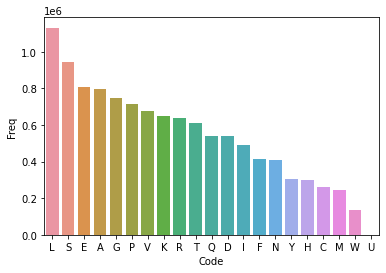

In [15]:
# eda code sequence

eda_code_freq = get_code_freq(eda_df['Sequence'], 'eda')
plot_code_freq(eda_code_freq, 'All')

In [16]:
# convert sequences into lists encoding 

amino_acid_encode = integer_encoding(eda_df) 

Length train: 16300
Length test: 2037
Length val: 2038


<ipython-input-17-e67dccd134cd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['seq_char_count']= df_train['Sequence'].apply(lambda x: len(x))
<ipython-input-17-e67dccd134cd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['seq_char_count']= df_val['Sequence'].apply(lambda x: len(x))
<ipython-input-17-e67dccd134cd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Codes: Train
Total unique codes: 21
Codes: Val
Total unique codes: 21
Codes: Test
Total unique codes: 21


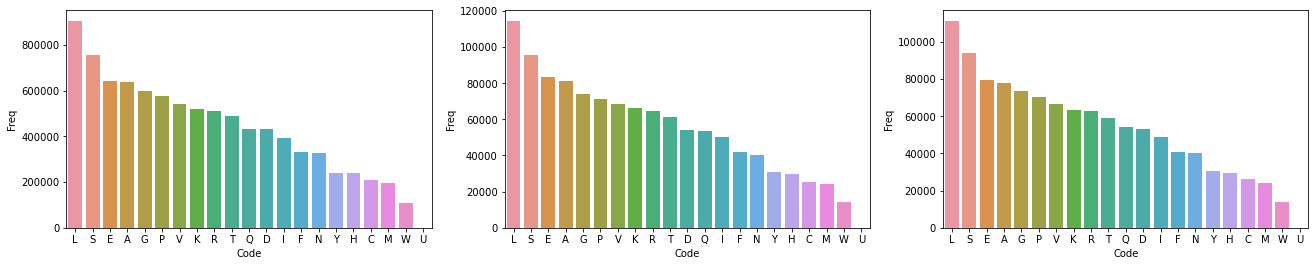

['Enzyme', 'Transporter', 'Nucleic acid binding', 'Transcription factor', 'Enzyme modulator', 'Kinase', 'G-protein coupled receptor', 'Signaling', 'Cellular structure', 'Ion channel', 'Receptor', 'Calcium-binding protein', 'Epigenetic regulator', 'Chaperone', 'Immune response', 'Extracellular structure', 'Cell adhesion', 'Cell-cell junction', 'Nuclear receptor', 'Storage', 'Surfactant']
Data size after considering 1000 classes for each data split:
Train size : 6244
Val size : 777
Test size : 766


In [17]:
# split the data

df_train, X_test = train_test_split(protein_disease_df, test_size=0.2, random_state=1)
df_test, df_val = train_test_split(X_test, test_size=0.5, random_state=1)

print("Length train: " + str(len(df_train)))
print("Length test: " + str(len(df_test)))
print("Length val: " + str(len(df_val)))

# # basic stats of df
# df_train.info()

# Length of sequence in train data.
df_train['seq_char_count']= df_train['Sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['Sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['Sequence'].apply(lambda x: len(x))

# plt.subplot(1, 3, 1)
# plot_seq_count(df_train, 'Train')

# plt.subplot(1, 3, 2)
# plot_seq_count(df_val, 'Val')

# plt.subplot(1, 3, 3)
# plot_seq_count(df_test, 'Test')

# plt.subplots_adjust(right=3.0)
# plt.show()

# train code sequence
train_code_freq = get_code_freq(df_train['Sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['Sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['Sequence'], 'Test')

plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


# Considering top 1000 classes based on most observations because of limited computational power.

classes = df_train['Protein_Class'].value_counts()[:1000].index.tolist()
print(classes)
# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['Protein_Class'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['Protein_Class'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['Protein_Class'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

# removed all NaNs

In [18]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

from keras.preprocessing.sequence import pad_sequences

max_length = 21
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

print(train_pad.shape, val_pad.shape, test_pad.shape)

from tensorflow.keras.utils import to_categorical

# One hot encoding of sequences
train_ohe = to_categorical(train_pad, 21)
val_ohe = to_categorical(val_pad, 21)
test_ohe = to_categorical(test_pad, 21)

print(train_ohe.shape, val_ohe.shape, test_ohe.shape) 

# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['Protein_Class'])
y_val_le = le.transform(val_sm['Protein_Class'])
y_test_le = le.transform(test_sm['Protein_Class'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

print('Total classes: ', len(le.classes_))
# le.classes_

(6244, 21) (777, 21) (766, 21)
(6244, 21, 21) (777, 21, 21) (766, 21, 21)
Total classes:  21


In [19]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [20]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

# model

x_input = Input(shape=(21, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(21, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model2.summary()

Epoch 1/100
49/49 [==============================] - 3s 35ms/step - loss: 3.6181 - accuracy: 0.1794 - val_loss: 3.3466 - val_accuracy: 0.1532
Epoch 2/100
49/49 [==============================] - 1s 30ms/step - loss: 2.9726 - accuracy: 0.2602 - val_loss: 3.3637 - val_accuracy: 0.1802
Epoch 3/100
49/49 [==============================] - 1s 30ms/step - loss: 2.7724 - accuracy: 0.2880 - val_loss: 3.2449 - val_accuracy: 0.2291
Epoch 4/100
49/49 [==============================] - 2s 39ms/step - loss: 2.6277 - accuracy: 0.3229 - val_loss: 3.2396 - val_accuracy: 0.2085
Epoch 5/100
49/49 [==============================] - 2s 35ms/step - loss: 2.5291 - accuracy: 0.3527 - val_loss: 3.1688 - val_accuracy: 0.2278
Epoch 6/100
49/49 [==============================] - 2s 37ms/step - loss: 2.4521 - accuracy: 0.3669 - val_loss: 3.0787 - val_accuracy: 0.2458
Epoch 7/100
49/49 [==============================] - 2s 40ms/step - loss: 2.3593 - accuracy: 0.3921 - val_loss: 2.8713 - val_accuracy: 0.2381
Epoch 

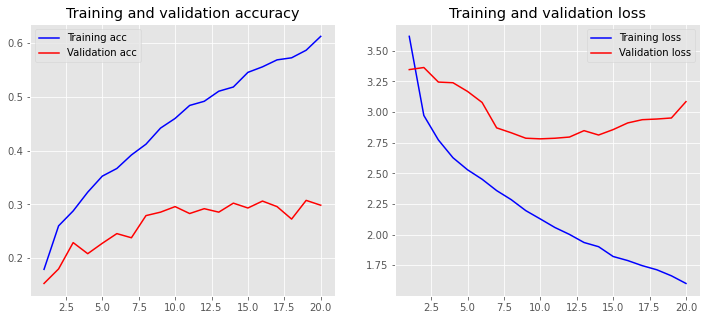

In [21]:
history = model2.fit(
    train_ohe, 
    y_train,
    epochs=100, 
    batch_size=128,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

plot_history(history)

In [22]:
## CLUSTERING

In [23]:
## Data preprocessing

corpus = protein_disease_df.loc[:,['Entry','Sequence']]
corpus.columns = ['id', 'sequence']
corpus['sequence'] = corpus['sequence'].map(list)
corpus.head()

,id,sequence
0,Q96NG5,"[M, A, A, V, I, L, P, S, T, A, A, P, S, S, L, ..."
1,Q6ZN19,"[M, L, E, G, H, E, S, Y, D, T, E, N, F, Y, F, ..."
2,Q9UI25,"[M, E, E, M, S, Y, G, E, N, S, G, T, H, V, G, ..."
3,Q86XN6,"[M, A, F, S, Q, G, L, L, T, F, R, D, V, A, I, ..."
4,A8MUZ8,"[M, H, S, L, K, K, L, T, F, E, D, V, A, I, D, ..."


In [24]:
## Compute SGT embeddings, utilizing pandarallel

pandarallel.initialize(progress_bar=True)
 
sgt_embedding = SGT(kappa=1, 
                   lengthsensitive=False, 
                   mode='multiprocessing')

sgt_df = sgt_embedding.fit_transform(corpus)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [25]:
# Set the id column as the dataframe index

sgt_df = sgt_df.set_index('id')

sgt_df.head()

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, U)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
Q96NG5,0.008220,0.000076,0.001211,0.000474,0.007133,0.000234,0.000072,0.001493,0.001435,0.002823,...,0.002088,2.370143e-07,3.600766e-03,4.267973e-03,0.001381,0.002451,0.0,0.002222,0.000001,7.559358e-08
Q6ZN19,0.000012,0.000011,0.000006,0.001078,0.009506,0.001949,0.002854,0.001320,0.000411,0.000192,...,0.001594,6.484061e-05,2.526795e-03,1.224862e-03,0.001520,0.000959,0.0,0.000212,0.000007,1.121458e-03
Q9UI25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018316,...,0.016596,4.961453e-08,2.003319e-08,1.569566e-17,0.003061,0.001239,0.0,0.000056,0.000000,0.000000e+00
Q86XN6,0.000015,0.000657,0.001919,0.000199,0.005137,0.001028,0.000348,0.001603,0.000499,0.000398,...,0.001459,4.701172e-07,2.277365e-03,1.112968e-03,0.001756,0.000197,0.0,0.001481,0.000655,1.669661e-06
A8MUZ8,0.000043,0.009299,0.006384,0.000062,0.019691,0.000106,0.001487,0.007376,0.001440,0.005418,...,0.003267,1.453150e-09,9.927638e-03,3.573656e-03,0.001482,0.004089,0.0,0.025989,0.000002,2.075606e-04


In [26]:
## Perform PCA with 2 components
# alternatively use n_components = 0.95 to find n_components maintaining 95% of data

pca = PCA(n_components=2) 
pca.fit(sgt_df)

X=pca.transform(sgt_df)

print("The variance ratio is " + str(np.sum(pca.explained_variance_ratio_)))
print("The ratio per x1 and x2 is " + str(pca.explained_variance_ratio_))
print("** A low variance ratio means the components don't explain as much of the data. \n** A high variance ratio means they explain more of the data.")

# convert X (array of lists/coordinates) to dataframe
coord_df = pd.DataFrame(data=X, columns=['x1','x2'])
coord_df.head()


The variance ratio is 0.08123632003540453
The ratio per x1 and x2 is [0.0693745  0.01186182]
** A low variance ratio means the components don't explain as much of the data. 
** A high variance ratio means they explain more of the data.


,x1,x2
0,-0.015398,0.001469
1,-0.052043,0.001760
2,0.210720,-0.010379
3,-0.044805,0.001575
4,0.005037,-0.004336


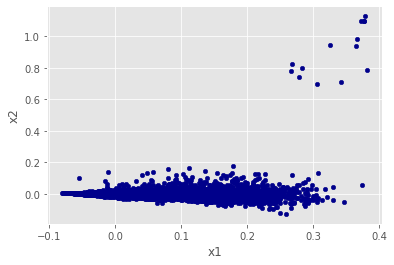

In [27]:
# Plot x1 and x2 points

ax1 = coord_df.plot.scatter(x='x1', y='x2', c='DarkBlue')


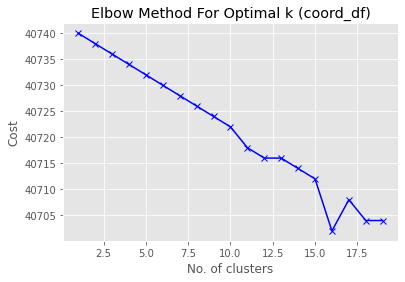

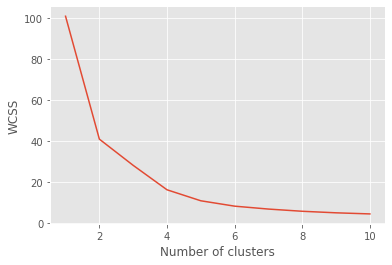

In [28]:
# Perform elbow method and kmeans to calculate optimized number of clusters (on coord_df)

# Elbow curve to find optimal K
cost = []
K = range(1,20)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(coord_df)
    cost.append(kmode.cost_) 
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k (coord_df)')
plt.show()

# Other method to find optimial K -> NEED TO CONVERT TO INT FIRST
wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit_predict(coord_df) 
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

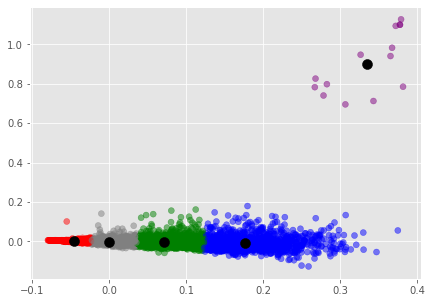

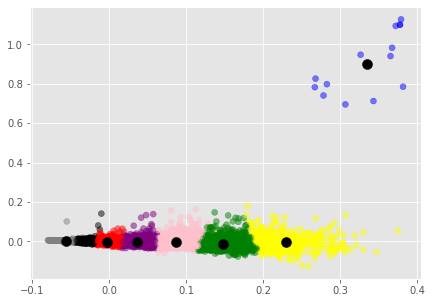

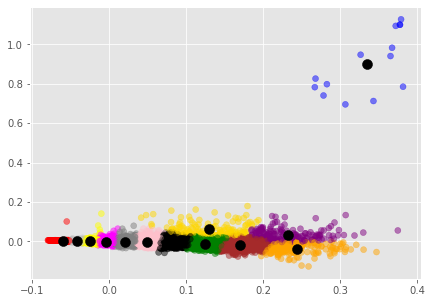

In [29]:
## Kmeans Clustering (5)

kmeans5 = KMeans(n_clusters=5, max_iter =300)
kmeans5.fit(coord_df)
labels5 = kmeans5.predict(coord_df)
centroids5 = kmeans5.cluster_centers_
fig = plt.figure(figsize=(7, 5))
colmap5 = {1: 'red', 2: 'green', 3: 'blue',4: 'grey', 5: 'purple'}
colors5 = list(map(lambda x: colmap5[x+1], labels5))
plt.scatter(coord_df['x1'], coord_df['x2'], color=colors5, alpha=0.5, edgecolor=colors5)
plt.scatter(kmeans5.cluster_centers_[:, 0], kmeans5.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')

## Kmeans Clustering (8)
kmeans8 = KMeans(n_clusters=8, max_iter =300)
kmeans8.fit(coord_df)
labels8 = kmeans8.predict(coord_df)
centroids8 = kmeans8.cluster_centers_
fig = plt.figure(figsize=(7, 5))
colmap8 = {1: 'red', 2: 'green', 3: 'blue',4: 'grey', 5: 'purple', 6: 'yellow', 7:'pink',8:'black'}
colors8 = list(map(lambda x: colmap8[x+1], labels8))
plt.scatter(coord_df['x1'], coord_df['x2'], color=colors8, alpha=0.5, edgecolor=colors8)
plt.scatter(kmeans8.cluster_centers_[:, 0], kmeans8.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')

## Kmeans Clustering (13)
kmeans13 = KMeans(n_clusters=13, max_iter =300)
kmeans13.fit(coord_df)
labels13 = kmeans13.predict(coord_df)
centroids13 = kmeans13.cluster_centers_
fig = plt.figure(figsize=(7, 5))
colmap13 = {1: 'red', 2: 'green', 3: 'blue',4: 'grey', 5: 'purple', 6: 'yellow', 7:'pink',8:'black',
         9: 'orange', 10: 'brown', 11: 'magenta', 12:'silver',13:'gold'}
colors13 = list(map(lambda x: colmap13[x+1], labels13))
plt.scatter(coord_df['x1'], coord_df['x2'], color=colors13, alpha=0.5, edgecolor=colors13)
plt.scatter(kmeans13.cluster_centers_[:, 0], kmeans13.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')


20375
16884


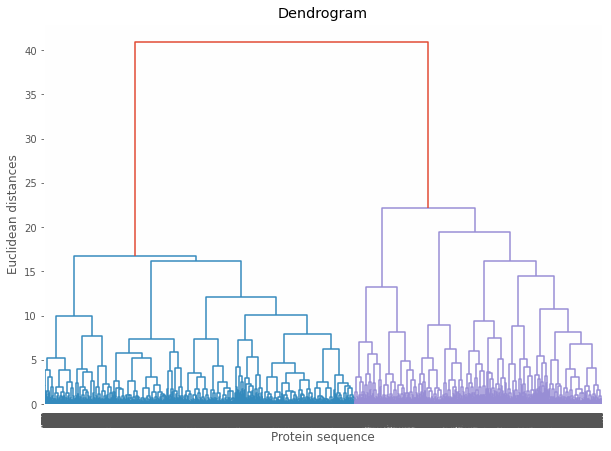

In [33]:
## Hierarchical Clustering

points = coord_df.to_numpy()

#encode the data
encoded_dataset = protein_disease_df.copy()
encoded_dataset = encoded_dataset[['Entry', 'Entry name', 'Protein names', 'Gene names', 'Function [CC]', 'Protein_Class', 'Length', 'Sequence', 'Gene_x','Gene_Full_Name', 'N_diseases', 'Disease']]
encoded_dataset['Entry'] = LabelEncoder().fit_transform(encoded_dataset['Entry'])
encoded_dataset['Entry name'] = LabelEncoder().fit_transform(encoded_dataset['Entry name'])
encoded_dataset['Protein names'] = LabelEncoder().fit_transform(encoded_dataset['Protein names'])
encoded_dataset['Gene names'] = LabelEncoder().fit_transform(encoded_dataset['Gene names'])
#encoded_dataset['Organism'] = LabelEncoder().fit_transform(encoded_dataset['Organism'])
encoded_dataset['Function [CC]'] = LabelEncoder().fit_transform(encoded_dataset['Function [CC]'])
encoded_dataset['Protein_Class'] = LabelEncoder().fit_transform(encoded_dataset['Protein_Class'])
encoded_dataset['Sequence'] = LabelEncoder().fit_transform(encoded_dataset['Sequence'])
encoded_dataset['Gene_Full_Name'] = LabelEncoder().fit_transform(encoded_dataset['Gene_Full_Name'])
encoded_dataset['Gene_x'] = LabelEncoder().fit_transform(encoded_dataset['Gene_x'])
encoded_dataset['Disease'] = LabelEncoder().fit_transform(encoded_dataset['Disease'])
print(len(encoded_dataset))
encoded_dataset.dropna(inplace=True)
data_scaled = normalize(encoded_dataset)
data_scaled = pd.DataFrame(data_scaled, columns=encoded_dataset.columns)
print(len(data_scaled))
# create dendrogram
plt.figure(figsize=(10, 7))  
plt.title('Dendrogram')
plt.xlabel('Protein sequence')
plt.ylabel('Euclidean distances')
dendrogram = sch.dendrogram(sch.linkage(data_scaled, method='ward'))
plt.show()



In [34]:
# # Scatter plot of Hierarchical clustering

# # create clusters
# hc = AgglomerativeClustering(n_clusters=8, affinity = 'euclidean', linkage = 'ward')

# # save clusters for chart
# y_hc = hc.fit_predict(points)

# plt.scatter(points[y_hc ==0,0], points[y_hc == 0,1], s=20, c='purple')
# plt.scatter(points[y_hc==1,0], points[y_hc == 1,1], s=20, c='grey')
# plt.scatter(points[y_hc ==2,0], points[y_hc == 2,1], s=20, c='yellow')
# plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=20, c='green')
# plt.scatter(points[y_hc ==4,0], points[y_hc == 4,1], s=20, c='red')
# plt.scatter(points[y_hc==5,0], points[y_hc == 5,1], s=20, c='blue')
# plt.scatter(points[y_hc ==6,0], points[y_hc == 6,1], s=20, c='pink')
# plt.scatter(points[y_hc ==7,0], points[y_hc == 7,1], s=20, c='black')


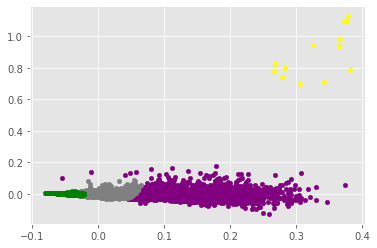

In [35]:
# Scatter plot of Hierarchical clustering

# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
y_hc = hc.fit_predict(points)

plt.scatter(points[y_hc ==0,0], points[y_hc == 0,1], s=20, c='purple')
plt.scatter(points[y_hc==1,0], points[y_hc == 1,1], s=20, c='grey')
plt.scatter(points[y_hc ==2,0], points[y_hc == 2,1], s=20, c='yellow')
plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=20, c='green')
# plt.scatter(points[y_hc ==4,0], points[y_hc == 4,1], s=20, c='red')
# plt.scatter(points[y_hc==5,0], points[y_hc == 5,1], s=20, c='blue')
# plt.scatter(points[y_hc ==6,0], points[y_hc == 6,1], s=20, c='pink')
# plt.scatter(points[y_hc ==7,0], points[y_hc == 7,1], s=20, c='black')


Text(0, 0.5, 'Feature 1')

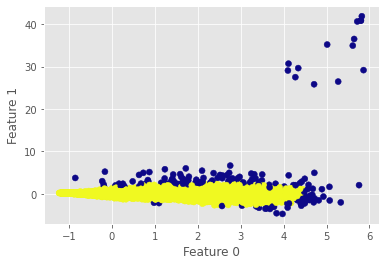

In [36]:
## Density Based Clustering

scaler = StandardScaler()
X_scaled = scaler.fit_transform(coord_df)

dbscan = DBSCAN(eps=0.3, min_samples = 10)
clusters = dbscan.fit_predict(X_scaled)

# plot the cluster assignments
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [37]:
## ANALYSIS

In [38]:
protein_disease_df.head()

,Entry,Entry name,Protein names,Gene names,Organism,Length,Function [CC],Sequence,Taxonomic lineage (all),Organism ID,...,Gene_id,Gene_Full_Name,Protein_Class,pLI,DSI_g,DPI_g,N_diseases,N_SNPs,Gene_y,Disease
0,Q96NG5,ZN558_HUMAN,Zinc finger protein 558,ZNF558,Homo sapiens (Human),402,FUNCTION: May be involved in transcriptional r...,MAAVILPSTAAPSSLFPASQQKGHTQGGELVNELLTSWLRGLVTFE...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q6ZN19,ZN841_HUMAN,Zinc finger protein 841,ZNF841,Homo sapiens (Human),808,FUNCTION: May be involved in transcriptional r...,MLEGHESYDTENFYFREIRKNLQEVDFQWKDGEINYKEGPMTHKNN...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,284371.0,zinc finger protein 841,Transcription factor,2.393100e-02,1.0,0.077,1.0,1.0,ZNF841,Asthma
2,Q9UI25,YP002_HUMAN,Putative uncharacterized protein PRO0461,PRO0461,Homo sapiens (Human),63,,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q86XN6,ZN761_HUMAN,Zinc finger protein 761,ZNF761 KIAA2033,Homo sapiens (Human),746,FUNCTION: May be involved in transcriptional r...,MAFSQGLLTFRDVAIEFSQEEWKCLDPAQRTLYRDVMLENYRNLVS...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A8MUZ8,Z705G_HUMAN,Putative zinc finger protein 705G,ZNF705G,Homo sapiens (Human),300,FUNCTION: May be involved in transcriptional r...,MHSLKKLTFEDVAIDFTQEEWAMMDTSKRKLYRDVMLENISHLVSL...,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,...,100131980.0,zinc finger protein 705G,None,1.647100e-08,NaN,NaN,1.0,1.0,ZNF705G,Blood Protein Measurement


In [39]:
## Add cluster color to df
protein_disease_df['cluster5'] = colors5
protein_disease_df['cluster8'] = colors8
protein_disease_df['cluster13'] = colors13

## add x1 and x2 values
protein_disease_df['x1'] = coord_df['x1']
protein_disease_df['x2'] = coord_df['x2']

In [40]:
grouped13 = protein_disease_df.groupby(protein_disease_df.cluster13)
grouped8 = protein_disease_df.groupby(protein_disease_df.cluster8)
grouped5 = protein_disease_df.groupby(protein_disease_df.cluster5)

In [41]:
# filter df by cluster13
black13_df = grouped13.get_group("black").reset_index()
purple13_df = grouped13.get_group("purple").reset_index()
red13_df = grouped13.get_group("red").reset_index()
yellow13_df = grouped13.get_group("yellow").reset_index()
grey13_df = grouped13.get_group("grey").reset_index()
pink13_df = grouped13.get_group("pink").reset_index()
green13_df = grouped13.get_group("green").reset_index()
blue13_df = grouped13.get_group("blue").reset_index()
orange13_df = grouped13.get_group("orange").reset_index()
brown13_df = grouped13.get_group("brown").reset_index()
magenta13_df = grouped13.get_group("magenta").reset_index()
silver13_df = grouped13.get_group("silver").reset_index()
gold13_df = grouped13.get_group("gold").reset_index()

black13_counts_df = black13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='black')
purple13_counts_df = purple13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='purple')
red13_counts_df = red13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='red')
yellow13_counts_df = yellow13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='yellow')
grey13_counts_df = grey13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='grey')
pink13_counts_df = pink13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='pink')
green13_counts_df = green13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='green')
blue13_counts_df = blue13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='blue')
orange13_counts_df = orange13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='orange')
brown13_counts_df = brown13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='brown')
magenta13_counts_df = magenta13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='magenta')
silver13_counts_df = silver13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='silver')
gold13_counts_df = gold13_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='gold')

function_count13_df = pd.merge(black13_counts_df,purple13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,red13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,yellow13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,grey13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,pink13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,green13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,blue13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,orange13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,brown13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,magenta13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,silver13_counts_df,on='Function',how='outer')
function_count13_df = pd.merge(function_count13_df,gold13_counts_df,on='Function',how='outer')

function_count13_df["sum"] = function_count13_df[['black','purple','red','yellow','grey','pink','green','blue','orange','brown','magenta','silver','gold']].sum(axis=1)
function_count13_df = function_count13_df.sort_values(by=['sum'], ascending=False, ignore_index=True).reset_index()

function_count13_df.head()


,index,Function,black,purple,red,yellow,grey,pink,green,blue,orange,brown,magenta,silver,gold,sum
0,0,,341.0,71.0,374.0,568.0,418.0,388.0,271.0,NaN,72.0,176.0,471.0,542.0,46.0,3738.0
1,1,FUNCTION: Odorant receptor. {ECO:0000305}.,1.0,NaN,NaN,3.0,20.0,NaN,NaN,NaN,NaN,NaN,386.0,NaN,NaN,410.0
2,2,FUNCTION: May be involved in transcriptional r...,7.0,NaN,27.0,135.0,7.0,4.0,2.0,NaN,NaN,1.0,29.0,156.0,NaN,368.0
3,3,FUNCTION: May be involved in transcriptional r...,NaN,NaN,10.0,33.0,4.0,1.0,NaN,NaN,NaN,NaN,2.0,23.0,NaN,73.0
4,4,"FUNCTION: In the hair cortex, hair keratin int...",8.0,2.0,NaN,3.0,13.0,27.0,5.0,NaN,1.0,NaN,6.0,NaN,3.0,68.0


In [42]:
# filter df by cluster8
black8_df = grouped8.get_group("black").reset_index()
purple8_df = grouped8.get_group("purple").reset_index()
red8_df = grouped8.get_group("red").reset_index()
yellow8_df = grouped8.get_group("yellow").reset_index()
grey8_df = grouped8.get_group("grey").reset_index()
pink8_df = grouped8.get_group("pink").reset_index()
green8_df = grouped8.get_group("green").reset_index()
blue8_df = grouped8.get_group("blue").reset_index()

black8_counts_df = black8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='black')
purple8_counts_df = purple8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='purple')
red8_counts_df = red8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='red')
yellow8_counts_df = yellow8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='yellow')
grey8_counts_df = grey8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='grey')
pink8_counts_df = pink8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='pink')
green8_counts_df = green8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='green')
blue8_counts_df = blue8_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='blue')

function_count8_df = pd.merge(black8_counts_df,purple8_counts_df,on='Function',how='outer')
function_count8_df = pd.merge(function_count8_df,red8_counts_df,on='Function',how='outer')
function_count8_df = pd.merge(function_count8_df,yellow8_counts_df,on='Function',how='outer')
function_count8_df = pd.merge(function_count8_df,grey8_counts_df,on='Function',how='outer')
function_count8_df = pd.merge(function_count8_df,pink8_counts_df,on='Function',how='outer')
function_count8_df = pd.merge(function_count8_df,green8_counts_df,on='Function',how='outer')
function_count8_df = pd.merge(function_count8_df,blue8_counts_df,on='Function',how='outer')

function_count8_df["sum"] = function_count8_df[['black','purple','red','yellow','grey','pink','green','blue']].sum(axis=1)
function_count8_df = function_count8_df.sort_values(by=['sum'], ascending=False, ignore_index=True).reset_index()

function_count8_df.head()


,index,Function,black,purple,red,yellow,grey,pink,green,blue,sum
0,0,,849.0,601.0,686.0,169.0,565.0,536.0,332.0,NaN,3738.0
1,1,FUNCTION: Odorant receptor. {ECO:0000305}.,2.0,2.0,405.0,NaN,NaN,1.0,NaN,NaN,410.0
2,2,FUNCTION: May be involved in transcriptional r...,237.0,5.0,42.0,NaN,72.0,9.0,3.0,NaN,368.0
3,3,FUNCTION: May be involved in transcriptional r...,46.0,2.0,6.0,NaN,19.0,NaN,NaN,NaN,73.0
4,4,"FUNCTION: In the hair cortex, hair keratin int...",2.0,37.0,9.0,4.0,NaN,11.0,5.0,NaN,68.0


In [43]:
# filter df by cluster5
purple5_df = grouped5.get_group("purple").reset_index()
blue5_df = grouped5.get_group("blue").reset_index()
red5_df = grouped5.get_group("red").reset_index()
green5_df = grouped5.get_group("green").reset_index()
grey5_df = grouped5.get_group("grey").reset_index()

purple5_counts_df = purple5_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='purple')
blue5_counts_df = blue5_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='blue')
red5_counts_df = red5_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='red')
green5_counts_df = green5_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='green')
grey5_counts_df = grey5_df['Function [CC]'].value_counts().rename_axis('Function').reset_index(name='grey')

function_count5_df = pd.merge(purple5_counts_df,blue5_counts_df,on='Function',how='outer')
function_count5_df = pd.merge(function_count5_df,red5_counts_df,on='Function',how='outer')
function_count5_df = pd.merge(function_count5_df,green5_counts_df,on='Function',how='outer')
function_count5_df = pd.merge(function_count5_df,grey5_counts_df,on='Function',how='outer')

function_count5_df["sum"] = function_count5_df[['purple','blue','red','green','grey']].sum(axis=1)
function_count5_df = function_count5_df.sort_values(by=['sum'], ascending=False, ignore_index=True).reset_index()

function_count5_df.head()


,index,Function,purple,blue,red,green,grey,sum
0,0,,NaN,450.0,1243.0,911.0,1134.0,3738.0
1,1,FUNCTION: Odorant receptor. {ECO:0000305}.,NaN,NaN,NaN,1.0,409.0,410.0
2,2,FUNCTION: May be involved in transcriptional r...,NaN,1.0,284.0,13.0,70.0,368.0
3,3,FUNCTION: May be involved in transcriptional r...,NaN,NaN,53.0,1.0,19.0,73.0
4,4,"FUNCTION: In the hair cortex, hair keratin int...",NaN,9.0,2.0,37.0,20.0,68.0


In [44]:
black13_disease_counts_df = black13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='black')
purple13_disease_counts_df = purple13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='purple')
red13_disease_counts_df = red13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='red')
yellow13_disease_counts_df = yellow13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='yellow')
grey13_disease_counts_df = grey13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='grey')
pink13_disease_counts_df = pink13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='pink')
green13_disease_counts_df = green13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='green')
blue13_disease_counts_df = blue13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='blue')
orange13_disease_counts_df = orange13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='orange')
brown13_disease_counts_df = brown13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='brown')
magenta13_disease_counts_df = magenta13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='magenta')
silver13_disease_counts_df = silver13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='silver')
gold13_disease_counts_df = gold13_df['Disease'].value_counts().rename_axis('Disease').reset_index(name='gold')

Disease_count13_df = pd.merge(black13_disease_counts_df,purple13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,red13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,yellow13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,grey13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,pink13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,green13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,blue13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,orange13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,brown13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,magenta13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,silver13_disease_counts_df,on='Disease',how='outer')
Disease_count13_df = pd.merge(Disease_count13_df,gold13_disease_counts_df,on='Disease',how='outer')

Disease_count13_df["sum"] = Disease_count13_df[['black','purple','red','yellow','grey','pink','green','blue','orange','brown','magenta','silver','gold']].sum(axis=1)
Disease_count13_df = Disease_count13_df.sort_values(by=['sum'], ascending=False, ignore_index=True).reset_index()

Disease_count13_df.head()

,index,Disease,black,purple,red,yellow,grey,pink,green,blue,orange,brown,magenta,silver,gold,sum
0,0,Carcinoma of lung,9.0,NaN,30.0,57.0,22.0,18.0,5.0,NaN,1.0,2.0,26.0,39.0,2.0,211.0
1,1,Primary malignant neoplasm,7.0,NaN,13.0,24.0,12.0,17.0,5.0,NaN,1.0,NaN,27.0,33.0,2.0,141.0
2,2,Adenocarcinoma,6.0,NaN,17.0,26.0,18.0,9.0,6.0,NaN,NaN,2.0,19.0,26.0,1.0,130.0
3,3,Liver carcinoma,2.0,NaN,7.0,17.0,7.0,10.0,8.0,NaN,2.0,4.0,9.0,21.0,2.0,89.0
4,4,B-Cell Lymphomas,3.0,NaN,15.0,10.0,11.0,2.0,1.0,NaN,NaN,4.0,16.0,12.0,NaN,74.0


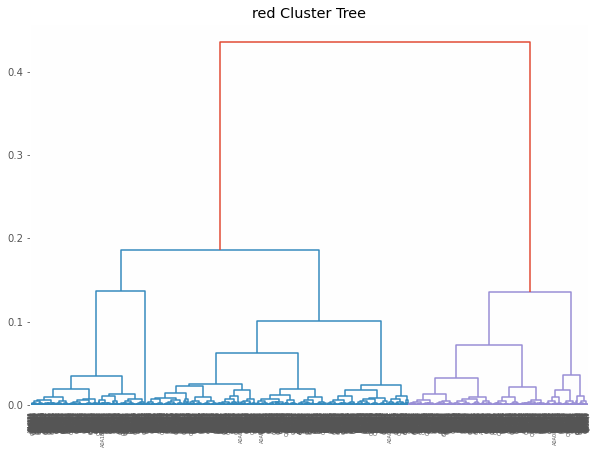

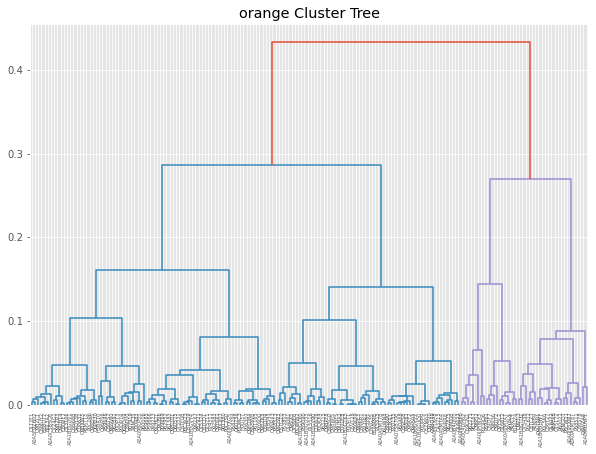

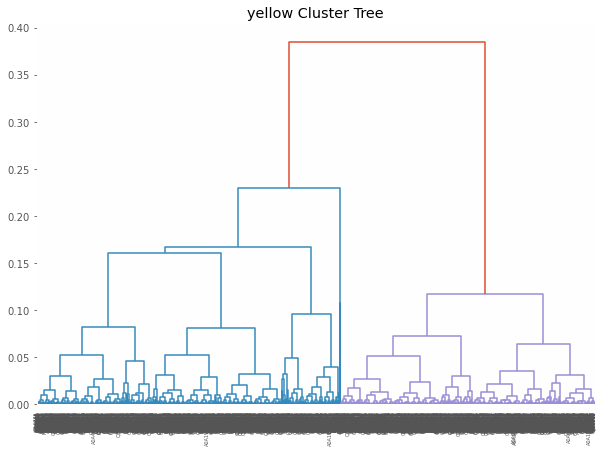

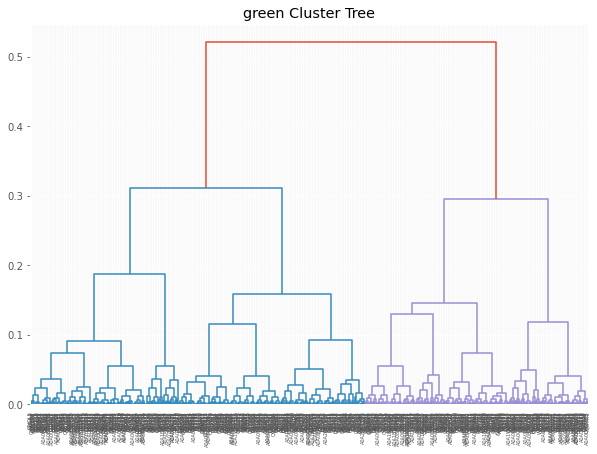

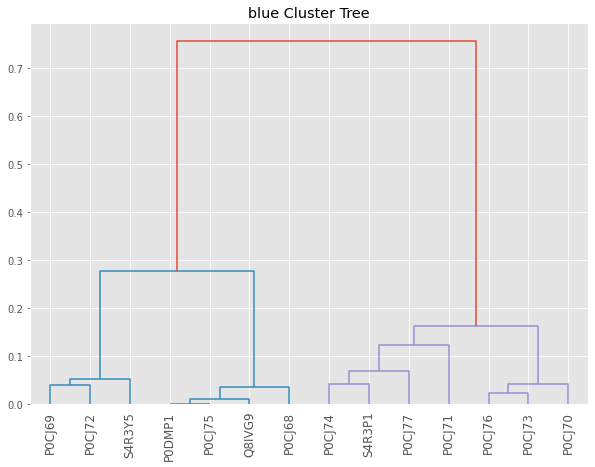

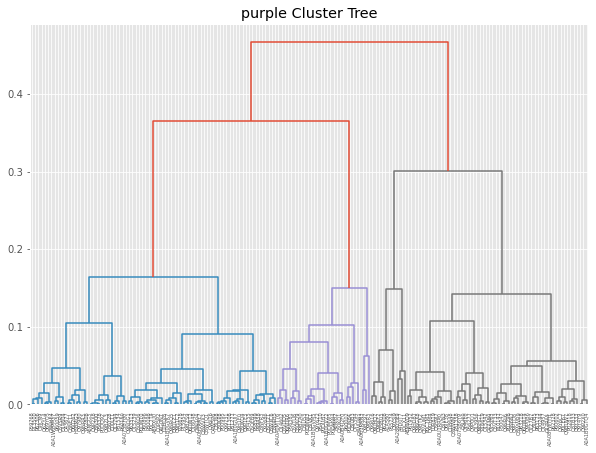

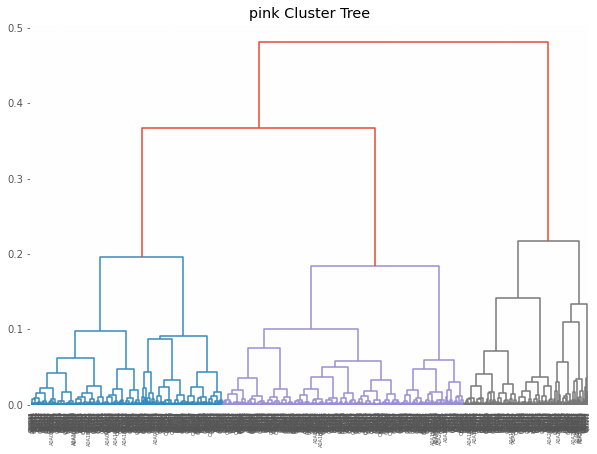

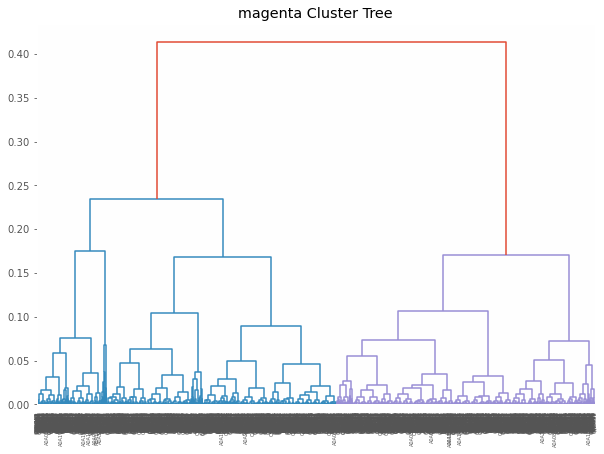

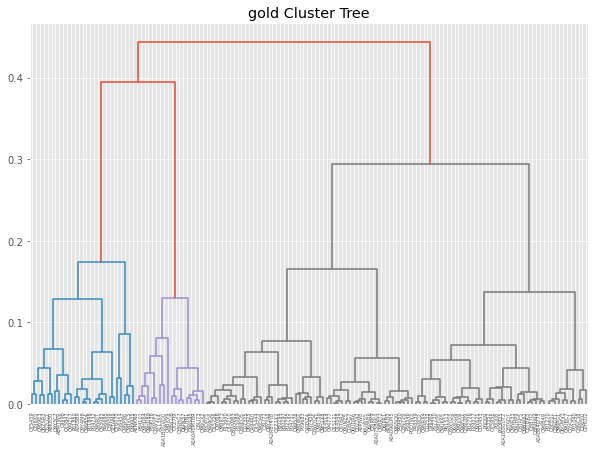

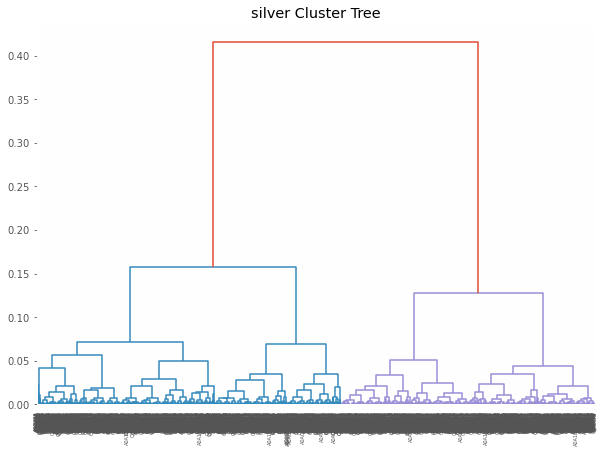

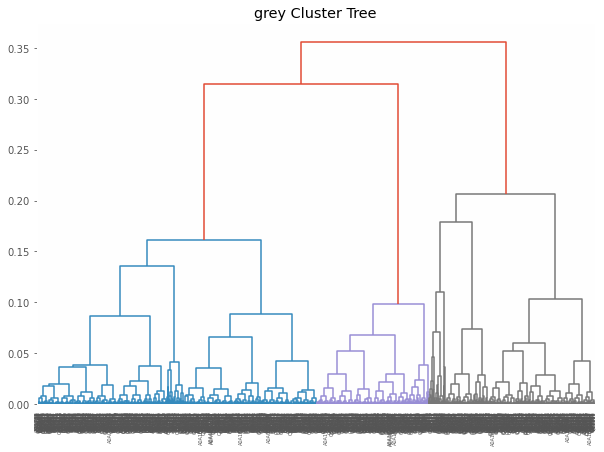

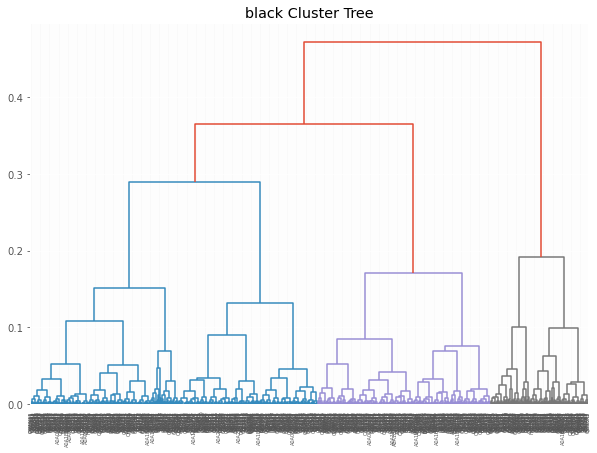

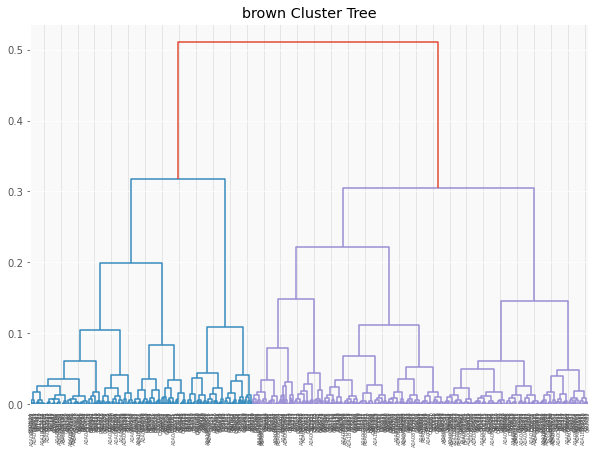

In [47]:
# Create Trees of Cluster13

cluster13_dfs = {'red':red13_df, 'orange':orange13_df, 'yellow':yellow13_df, 'green':green13_df, 'blue':blue13_df,
               'purple':purple13_df, 'pink':pink13_df, 'magenta':magenta13_df,'gold':gold13_df, 'silver':silver13_df, 
               'grey':grey13_df, 'black':black13_df, 'brown':brown13_df}

for key in cluster13_dfs:
    tree_dict = {}
    for i in range(len(cluster13_dfs[key])):
        tree_dict[cluster13_dfs[key]['Entry'][i]] = [cluster13_dfs[key]['x1'][i], cluster13_dfs[key]['x2'][i]]

    pairs = np.array(list(tree_dict.values()))
    linked = linkage(pairs, 'ward')
    tree_labels = list(tree_dict.keys())

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=tree_labels,
                leaf_rotation = 90,
                distance_sort='descending',
                show_leaf_counts=True)

    plt.title(str(key) + ' Cluster Tree')
    plt.show()

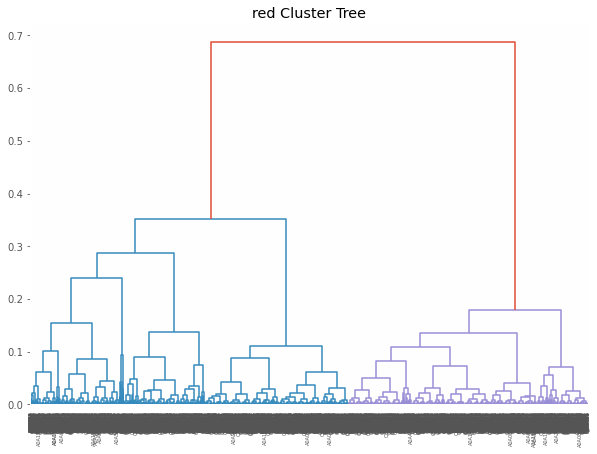

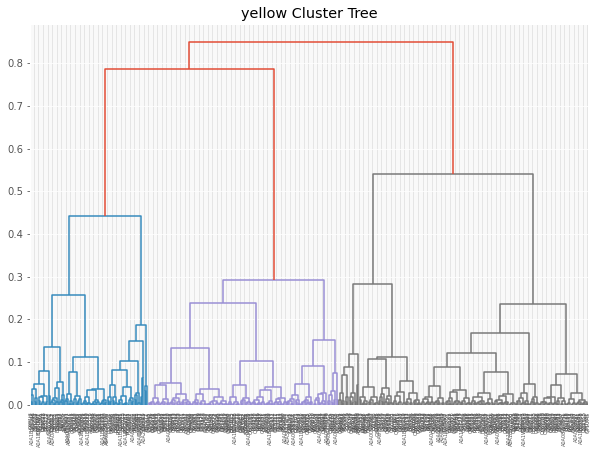

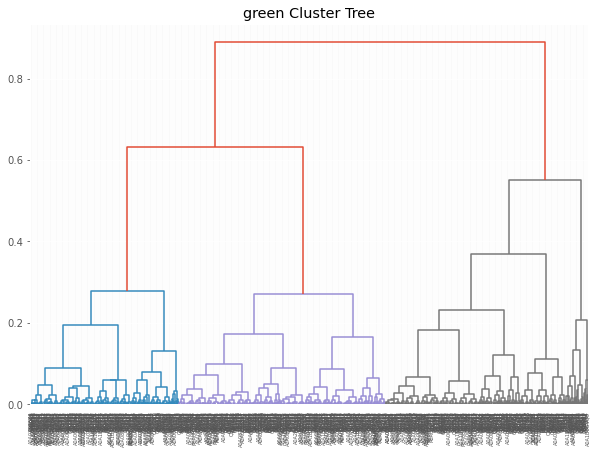

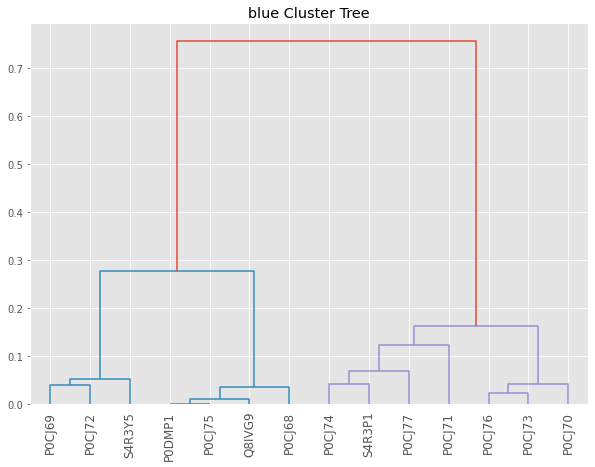

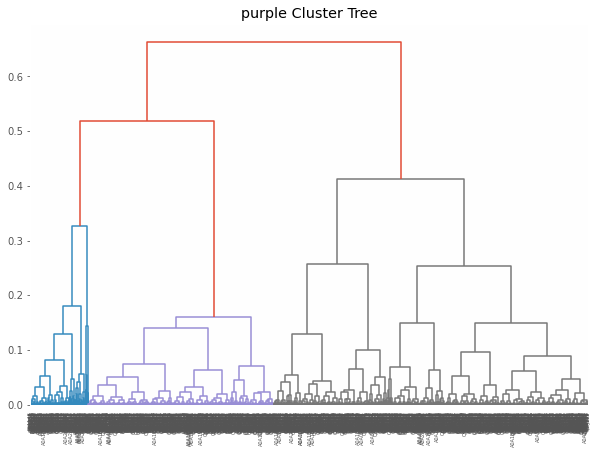

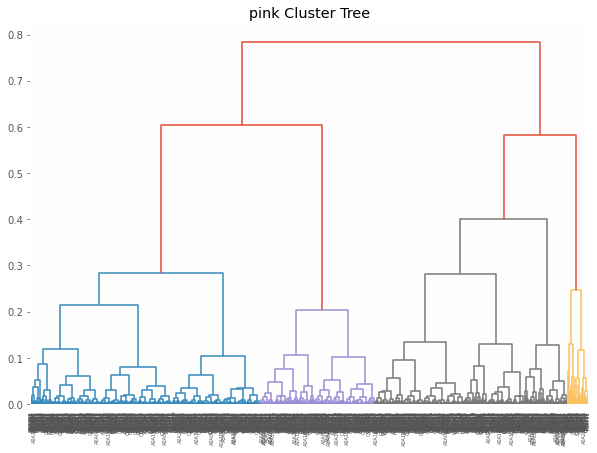

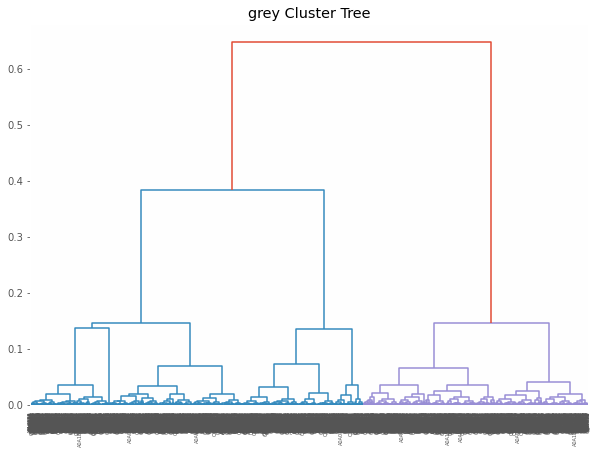

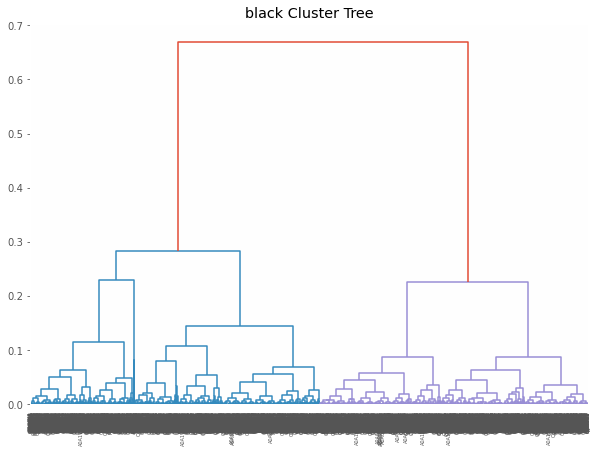

In [48]:
# Create Trees of Cluster8

cluster8_dfs = {'red':red8_df, 'yellow':yellow8_df, 'green':green8_df, 'blue':blue8_df,
               'purple':purple8_df, 'pink':pink8_df, 'grey':grey8_df, 'black':black8_df}

for key in cluster8_dfs:
    tree_dict = {}
    for i in range(len(cluster8_dfs[key])):
        tree_dict[cluster8_dfs[key]['Entry'][i]] = [cluster8_dfs[key]['x1'][i], cluster8_dfs[key]['x2'][i]]

    pairs = np.array(list(tree_dict.values()))
    linked = linkage(pairs, 'ward')
    tree_labels = list(tree_dict.keys())

    plt.figure(figsize=(10, 7))
    
    dendrogram(linked,
                orientation='top',
                labels=tree_labels,
                leaf_rotation = 90,
                distance_sort='descending',
                show_leaf_counts=True)
    
    plt.title(str(key) + ' Cluster Tree')
    plt.show()

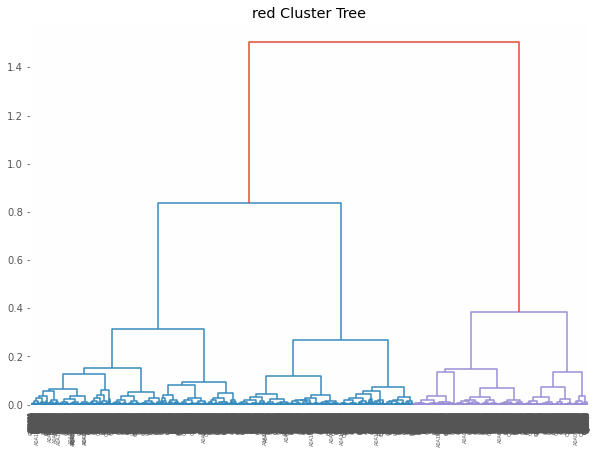

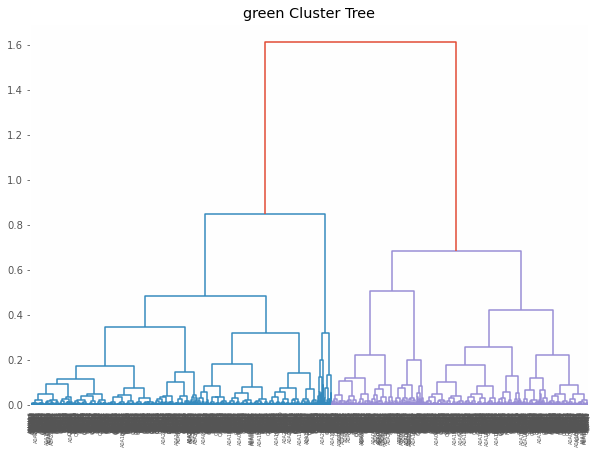

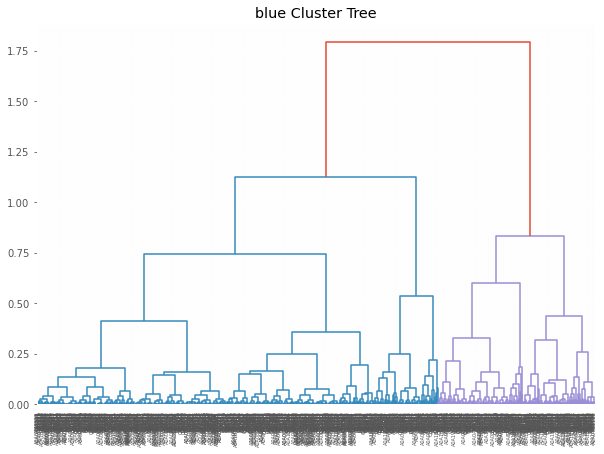

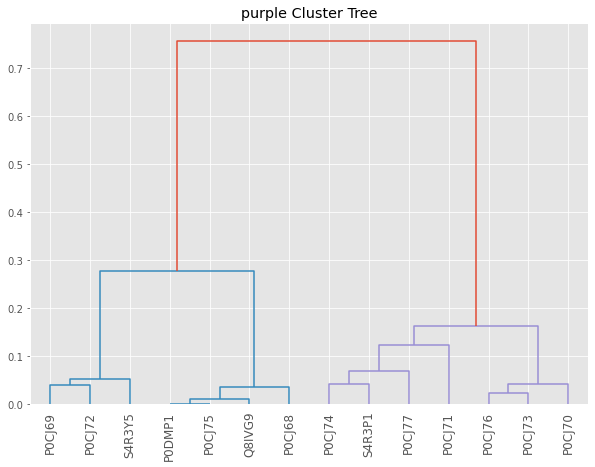

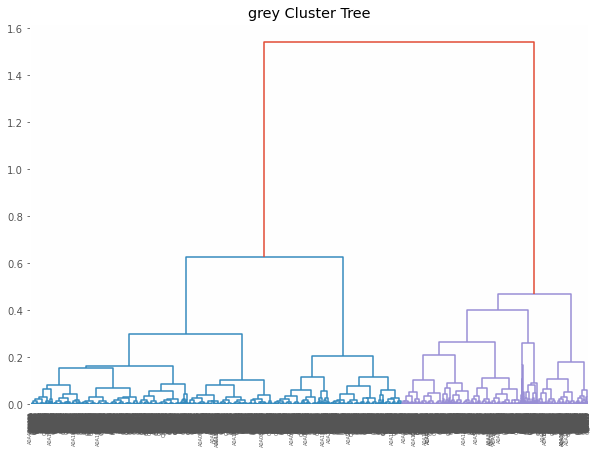

In [49]:
# Create Trees of Cluster5

cluster5_dfs = {'red':red5_df, 'green':green5_df, 'blue':blue5_df,'purple':purple5_df, 'grey':grey5_df}

for key in cluster5_dfs:
    tree_dict = {}
    for i in range(len(cluster5_dfs[key])):
        tree_dict[cluster5_dfs[key]['Entry'][i]] = [cluster5_dfs[key]['x1'][i], cluster5_dfs[key]['x2'][i]]

    pairs = np.array(list(tree_dict.values()))
    linked = linkage(pairs, 'ward')
    tree_labels = list(tree_dict.keys())

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=tree_labels,
                leaf_rotation = 90,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title(str(key) + ' Cluster Tree')
    plt.show()

In [52]:
## Search function seen in grey

#function_count5_df.loc[function_count5_df['Function'] == 'FUNCTION: Plays a role as a neuroprotective and antiapoptotic factor. {ECO:0000250|UniProtKB:Q8IVG9}.']

# print(function_count8_df.loc[function_count8_df['Function'] == 'FUNCTION: Plays a role as a neuroprotective and antiapoptotic factor. {ECO:0000250|UniProtKB:Q8IVG9}.'])

function_count13_df.loc[function_count13_df['Function'] == 'FUNCTION: Plays a role as a neuroprotective and antiapoptotic factor. {ECO:0000250|UniProtKB:Q8IVG9}.']



,index,Function,black,purple,red,yellow,grey,pink,green,blue,orange,brown,magenta,silver,gold,sum
23,23,FUNCTION: Plays a role as a neuroprotective an...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,12.0


In [57]:
L1_cluser_transfer_df = protein_disease_df.copy()
L1_cluser_transfer_df = L1_cluser_transfer_df[["cluster5"]]
L1_cluser_transfer_df = L1_cluser_transfer_df.groupby(L1_cluser_transfer_df.columns.tolist(),as_index=False).size()
L1_cluser_transfer_df.sort_values(by=['size'], ascending=False).reset_index(drop=True)

,cluster5,size
0,red,9645
1,grey,6490
2,green,2886
3,blue,1340
4,purple,14


In [58]:
L2_cluser_transfer_df = protein_disease_df.copy()
L2_cluser_transfer_df = L2_cluser_transfer_df[["cluster5", "cluster8"]]
L2_cluser_transfer_df = L2_cluser_transfer_df.groupby(L2_cluser_transfer_df.columns.tolist(),as_index=False).size()
L2_cluser_transfer_df.sort_values(by=['size'], ascending=False).reset_index(drop=True)

,cluster5,cluster8,size
0,red,grey,5077
1,red,black,4568
2,grey,red,4209
3,green,pink,1542
4,green,purple,1220
5,grey,purple,1191
6,grey,black,1090
7,blue,green,903
8,blue,yellow,436
9,green,green,124


In [59]:
L3_cluser_transfer_df = protein_disease_df.copy()
L3_cluser_transfer_df = L3_cluser_transfer_df[["cluster5","cluster8","cluster13"]]
L3_cluser_transfer_df = L3_cluser_transfer_df.groupby(L3_cluser_transfer_df.columns.tolist(),as_index=False).size()
L3_cluser_transfer_df.sort_values(by=['size'], ascending=False).reset_index(drop=True)

,cluster5,cluster8,cluster13,size
0,red,grey,red,3456
1,grey,red,magenta,3128
2,red,black,silver,2473
3,red,black,yellow,2095
4,red,grey,silver,1621
5,green,purple,pink,1215
6,grey,purple,grey,1168
7,grey,black,yellow,1090
8,green,pink,black,1055
9,grey,red,grey,634
